# Run QASVM on IBMQ devices (montreal, toronto)

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# TODO: choose config
I_HAVE_ACCESS = False # True
DATA_TYPE = 'balanced' # 'unbalanced'
DEVICE = 'montreal' # 'toronto'
TEST_SIZE = 30
MAXITER = 2**10
LAST_AVG = 2**4
DIR_NAME = 'ibmq_device_run_results'

C=None
k=1

In [2]:
# for SVM
from classifiers.convex.svm import BinarySVM
from classifiers.kernel import Kernel
from classifiers.datasets.dataloader import Example_4x2
# for QASVM
from classifiers.quantum import Qasvm_Mapping_4x2
from classifiers.quantum.qasvm import QASVM
from classifiers.quantum.quantum_circuits import AnsatzCircuit9
from classifiers.optimizer import SPSA
from qiskit.utils import QuantumInstance
from qiskit.ignis.mitigation import CompleteMeasFitter
from qiskit.circuit.library import RealAmplitudes, EfficientSU2, NLocal, TwoLocal
from qiskit.providers.aer import AerSimulator
from qiskit import IBMQ
# for logging & visualization
import logging
from classifiers.callback import CostParamStorage
from torch.utils.tensorboard import SummaryWriter
from classifiers.visualization import Plot_Data, Plot_Log_From_SPSA, Plot_SVM, compare_svm_and_qasvm
if I_HAVE_ACCESS:
    if IBMQ.active_account() is None:
        IBMQ.load_account()
    provider = IBMQ.get_provider(hub='ibm-q-skku', group='skku', project='saint') # TODO: your provider
    backend = provider.get_backend(f'ibmq_{DEVICE}')
else:
    import dill
    with open(f'./summary_ipynb/2021/06 June/03 Thu/naive({DEVICE})/ibmq_{DEVICE}', 'rb') as _f:
        backend = dill.load(_f)

backend

<IBMQBackend('ibmq_montreal') from IBMQ(hub='ibm-q-kaist', group='internal', project='default')>

## How to pick `layout`

### Priority 1. Should be one of four

- (yi - i1 - i0 - xi - a - xj - j0 - j1 - yj) connection
- (i1 - i0 - xi - a - xj - j0 - j1) + (i0 - yi) + (j0 - yj) connection
- (yi - i0 - i1 - xi - a - xj - j1 - j0 - yj) connection
- (i0 - i1 - xi - a - xj - j1 - j0) + (i1 - yi) + (j1 - yj) connection

### Priority 2. Should minimize TwoQubit (gate) error of possible connections in layout

### Priority 3. Should minimize SingleQubit (gate) error of qubits in layoyt

### Priority 4. Overall error on `*i` register should be lower than error on `*j` register

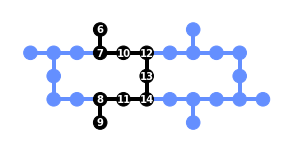

In [3]:
# e.g.
# layout = Qasvm_Mapping_4x2(backend, a=3, i0=8, i1=11, xi=5, yi=14, j0=1, j1=4, xj=2, yj=7)
# layout = Qasvm_Mapping_4x2(backend, a=16, i0=11, i1=8, xi=14, yi=5, j0=22, j1=25, xj=19, yj=24)
# layout = Qasvm_Mapping_4x2(backend, a=3, i0=9, i1=11, xi=5, yi=8, j0=0, j1=4, xj=2, yj=1)
layout = Qasvm_Mapping_4x2(backend, a=13, i0=10, i1=7, xi=12, yi=6, j0=11, j1=8, xj=14, yj=9) # TODO: Choose layout
layout.plot('physical')

In [4]:
import json
from pathlib import Path
DATA_DIR = Path.cwd()/DIR_NAME/f'{DATA_TYPE}'/f'{DEVICE}'
DATA_DIR.mkdir(exist_ok = True, parents=True)

with open(DATA_DIR / 'layout.json', 'w') as fp:
    json.dump(layout.json_layout, fp)

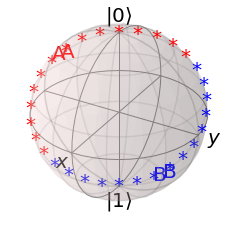

In [5]:
%matplotlib inline
_EPS = 0.01
X, y = Example_4x2(DATA_TYPE=='balanced')()
ax = plt.axes(projection='3d')

from qiskit.visualization.bloch import Bloch
B = Bloch(axes=ax)

def s2c(x):
    bloch = [1, x[0], x[1]]
    r, theta, phi = bloch[0], bloch[1], bloch[2]
    bloch[0] = r * np.sin(theta) * np.cos(phi)
    bloch[1] = r * np.sin(theta) * np.sin(phi)
    bloch[2] = r * np.cos(theta)
    return bloch

def c2s(bloch):
    x = [np.arccos(bloch[2]), np.arctan(bloch[1]/bloch[0])]
    return x

vecs = np.array(list(map(s2c, X)))
for v in vecs[y==0]:
    B.add_annotation(v, text='A', color='r')
for v in vecs[y==1]:
    B.add_annotation(v, text='B', color='b')
# B.add_annotation(vecs.mean(axis=0), text='M', color='k')
vecA = vecs[y==0].mean(axis=0)
vecA = vecA/np.linalg.norm(vecA)
vecB = vecs[y==1].mean(axis=0)
vecB = vecB/np.linalg.norm(vecB)
vecP = (vecA-vecB)/np.linalg.norm(vecA-vecB)
vecQ = -(vecA-vecB)/np.linalg.norm(vecA-vecB)
#B.add_annotation(vecP, text='P', color='r')
#B.add_annotation(vecQ, text='Q', color='b')

def test_data_gen(n, vecP, vecQ):
    Xt = np.array([np.linspace(0, 2*np.pi, n+1), c2s(vecP)[1]*np.ones(n+1)]).T
    Xt = Xt[1:]
    yt = np.where(np.dot(np.array(list(map(s2c, Xt))), vecP-vecQ)<0, 1, 0)
    return Xt, yt

Xt, yt = test_data_gen(TEST_SIZE, vecP, vecQ)

vecs = np.array(list(map(s2c, Xt)))
for v in vecs[yt==0]:
    B.add_annotation(v, text='*', color='r')
for v in vecs[yt==1]:
    B.add_annotation(v, text='*', color='b')

B.render()

71
69


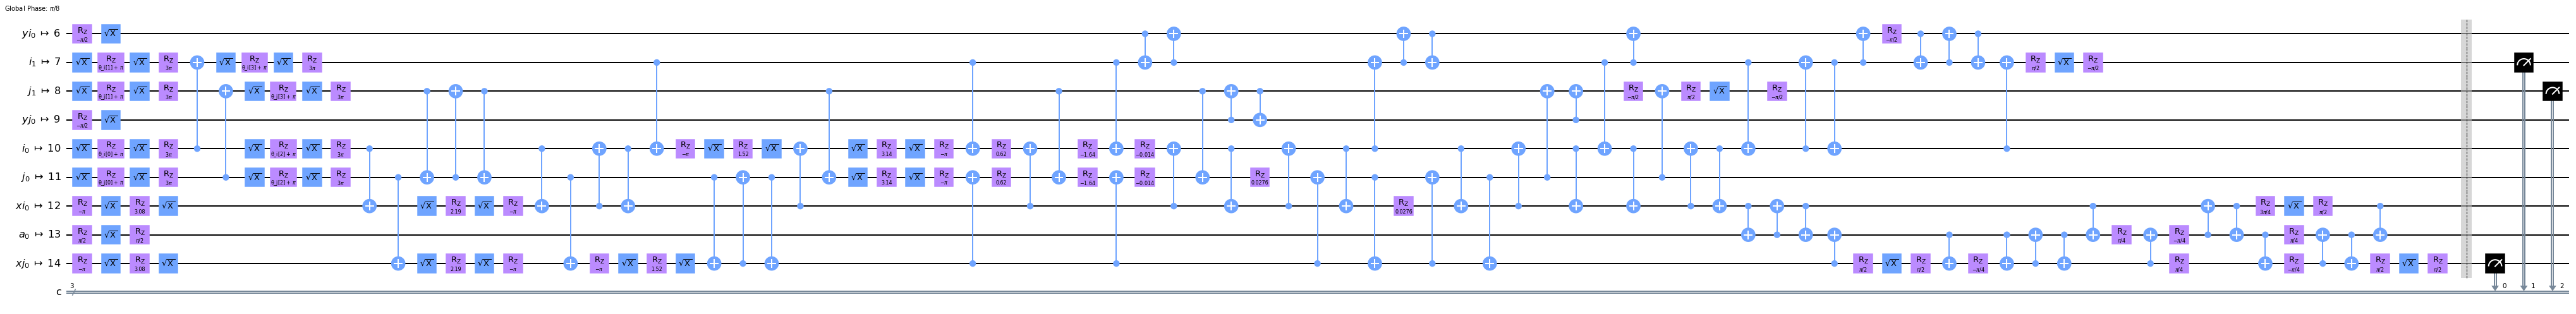

In [6]:
var_form = RealAmplitudes(2, reps=1)
#var_form = AnsatzCircuit9(2, reps=1, rotational_block='rx', entangling_block='cz')
#var_form = TwoLocal(2, reps=5, rotation_blocks='rz', entanglement_blocks='cx', entanglement='linear')
#var_form = EfficientSU2(2, reps=1)
quantum_instance = QuantumInstance(backend, shots=2**13, seed_transpiler=100, optimization_level=2, initial_layout=layout, measurement_error_mitigation_cls=CompleteMeasFitter)
qasvm = QASVM(X, y, quantum_instance=quantum_instance, C=None, k=10, option='Bloch_sphere', var_form=var_form).dual
print(qasvm.second_order_circuit.depth())
print(qasvm.first_order_circuit.depth())
qasvm.second_order_circuit.draw(fold=-1, output='mpl', idle_wires=False)

In [7]:
from tqdm.notebook import tqdm
def find_min_seed(quantum_instance):
    old_tv = 1000
    for i in tqdm(range(100)):
        old_seed = quantum_instance.compile_config['seed_transpiler']
        quantum_instance.compile_config['seed_transpiler'] = i
        qasvm = QASVM(X, y, quantum_instance=quantum_instance, C=None, k=10, option='Bloch_sphere', var_form=var_form).dual
        new_tv = qasvm.second_order_circuit.depth() + qasvm.first_order_circuit.depth() + np.abs(qasvm.second_order_circuit.depth() - qasvm.first_order_circuit.depth())**2
        if new_tv < old_tv:
            old_tv = new_tv
        else:
            quantum_instance.compile_config['seed_transpiler'] = old_seed
    return quantum_instance.compile_config['seed_transpiler']


In [8]:
seed=find_min_seed(quantum_instance)
print(seed)

  0%|          | 0/100 [00:00<?, ?it/s]

26


In [9]:
from copy import deepcopy
real_qi =  QuantumInstance(backend, shots=2**13, seed_transpiler=seed, optimization_level=2, initial_layout=layout, measurement_error_mitigation_cls=CompleteMeasFitter)
sim_qi = QuantumInstance(AerSimulator.from_backend(backend), shots=2**13, seed_transpiler=seed, optimization_level=2, initial_layout=layout, measurement_error_mitigation_cls=CompleteMeasFitter)
exact_qi = deepcopy(sim_qi)
exact_qi.backend.set_options(noise_model=None)

62
63


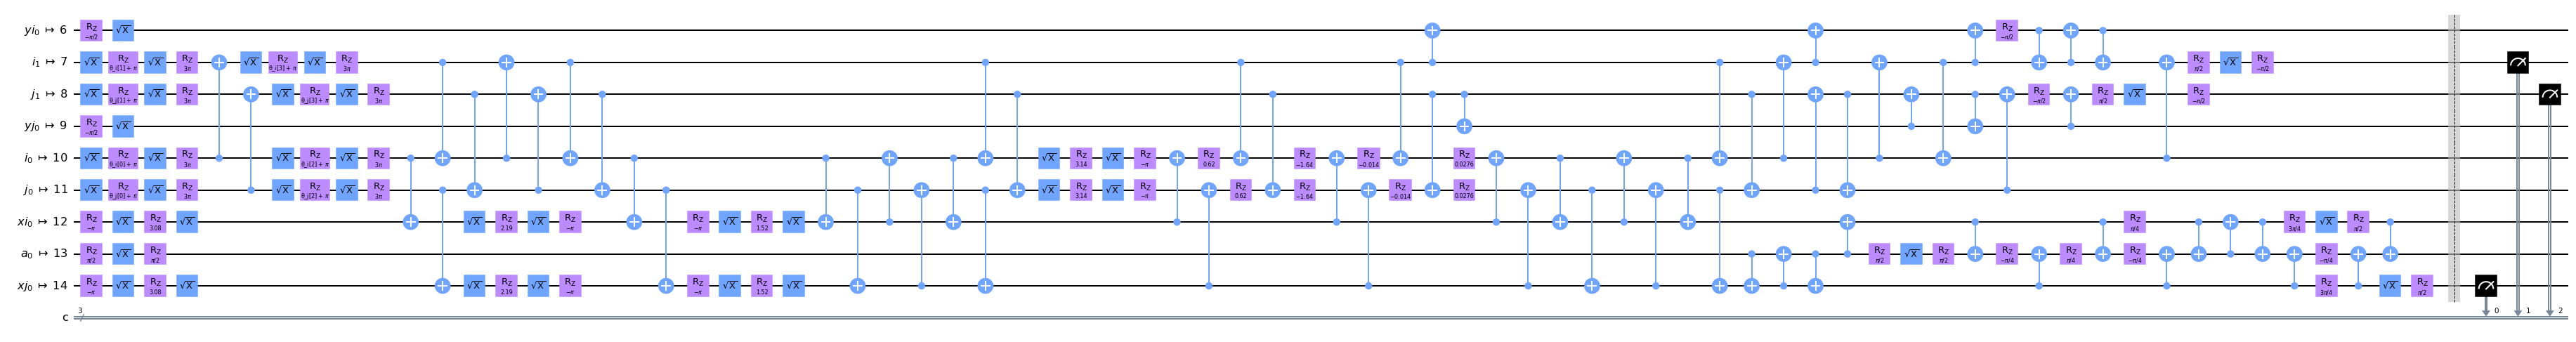

In [10]:
real_qasvm = QASVM(X, y, quantum_instance=real_qi, C=C, k=k, option='Bloch_sphere', var_form=var_form).dual
print(real_qasvm.second_order_circuit.depth())
print(real_qasvm.first_order_circuit.depth())
real_qasvm.second_order_circuit.draw(fold=-1, output='mpl', idle_wires=False)

In [11]:
sim_qasvm = deepcopy(real_qasvm)
sim_qasvm._quantum_instance = sim_qi
exact_qasvm = deepcopy(real_qasvm)
exact_qasvm._quantum_instance = exact_qi

uniform_qasvm = QASVM(X, y, quantum_instance=exact_qi, C=C, k=k, option='Bloch_uniform', var_form=None).dual

from qiskit.providers.ibmq import IBMQ
IBMQ.load_account()
simulator = IBMQ.get_provider(hub='ibm-q', group='open', project='main').get_backend('ibmq_qasm_simulator')

simulator_qi = QuantumInstance(simulator, shots=2**13, seed_transpiler=seed, optimization_level=2, initial_layout=layout, measurement_error_mitigation_cls=CompleteMeasFitter)
simulator_qasvm = deepcopy(real_qasvm)
simulator_qasvm._quantum_instance = simulator_qi


In [12]:
from tqdm.notebook import tqdm

# if this works, then any error in `ibmq_device_run.ipynb` is from qiskit itself.

print('Have Access')
random_parameters = np.random.rand(simulator_qasvm.num_parameters)
print(simulator_qasvm.cost_fn(random_parameters))
print(simulator_qasvm.f(X))


Have Access


measurement_error_mitigation_cls activated. result.get_count() contains mitigated, read out calibration, and unmitigated results
measurement_error_mitigation_cls activated. result.get_count() contains mitigated, read out calibration, and unmitigated results


[{'000': 8192.0}, {'001': 8192}, {'010': 8192}, {'011': 8192}, {'100': 8192}, {'101': 8192}, {'110': 8192}, {'111': 8192}, {'000': 51, '010': 338, '011': 271, '100': 315, '101': 294, '110': 6919, '111': 4}]
2.0
[-1.48803705 -1.45410155 -0.46289054 -0.47094724]


In [13]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright

/home/quic/anaconda3/envs/qiskit/lib/python3.9/site-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')
